In [1]:
# Quick demo of the PubMed corpus module
#import sys
#sys.path.append("../src")

from src.corpus import PubMedDownloader, DataProcessor
import os
from dotenv import load_dotenv

load_dotenv()



True

In [2]:
# Initialize and download
downloader = PubMedDownloader(
    api_key=os.getenv("NCBI_API_KEY"), 
    email=os.getenv("EMAIL")
)

# Download small test corpus
articles = downloader.download_articles(
    query="bacterial pneumonia", 
    max_results=20,
    batch_size=10
)



Searching PMC for: bacterial pneumonia
Found 20 articles
Processing batch 1 (10 articles)...
Skipping PMC12133358 due to license: other
Added PMC12133291 (license: cc-by)
Added PMC12132865 (license: cc-by)
Added PMC12132861 (license: cc-by)
Skipping PMC12132666 due to license: cc-by-nc-nd
Added PMC12132021 (license: cc-by)
Skipping PMC12131852 due to license: cc-by-nc-nd
Added PMC12131838 (license: cc-by)
Added PMC12131826 (license: cc-by)
Added PMC12131823 (license: cc-by)
Processing batch 2 (10 articles)...
Added PMC12131815 (license: cc-by)
Added PMC12131798 (license: cc-by)
Added PMC12131797 (license: cc-by)
Added PMC12131781 (license: cc-by)
Skipping PMC12131777 due to license: cc-by-nc-nd
Added PMC12131769 (license: cc-by)
Added PMC12131763 (license: cc-by)
Skipping PMC12131757 due to license: cc-by-nc-nd
Added PMC12131711 (license: cc-by)
Skipping PMC12131628 due to license: cc-by-nc-nd

Download complete:
- Downloaded: 14 articles
- Skipped: 6 articles


In [3]:
# Process and save
cleaned = DataProcessor.clean_articles(articles)
DataProcessor.save_articles_jsonl(cleaned, "data/processed/test_corpus.jsonl")

# Quick stats
stats = DataProcessor.get_corpus_stats(cleaned)
print(f"Downloaded {stats['total_articles']} articles")
print(f"Licenses: {stats['license_distribution']}")

Cleaned 14 valid articles out of 14
Saved 14 articles to data/processed/test_corpus.jsonl
Downloaded 14 articles
Licenses: {'cc-by': 14}


In [4]:
from src.rag import DocumentProcessor, create_index, create_query_engine, query_medical_rag
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.openai import OpenAI

/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:


# Load and process articles
articles = DocumentProcessor.load_medical_articles("data/processed/test_corpus.jsonl")
documents = DocumentProcessor.process_articles(articles)

In [6]:
# Create embedding model and index
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")
index = create_index(documents, embed_model, chunk_size=512, chunk_overlap=50, index_path="data/indices/medical_index")

Created 224 nodes using sentence splitting
Created and saved index with 224 nodes


In [7]:
# Create query engine and ask questions
llm = OpenAI(model="gpt-4o-2024-11-20", temperature=0.1)
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")
query_engine = create_query_engine("data/indices/medical_index", llm, embed_model)
answer = query_medical_rag("What are common treatments for pneumonia?", query_engine, embed_model)

In [12]:
print(answer)

Common treatments for pneumonia typically include the use of antibiotics to target bacterial infections, with the choice of antibiotic guided by the suspected or confirmed causative organism and its antimicrobial susceptibility. Supportive care measures, such as oxygen therapy for patients with respiratory distress or hypoxemia, and fluids to maintain hydration, are also commonly employed. In cases of severe pneumonia, particularly in intensive care settings, mechanical ventilation or noninvasive positive pressure ventilation may be required. For patients with hospital-acquired pneumonia, careful selection and monitoring of antibiotics are crucial to address multidrug-resistant organisms. Additionally, managing underlying conditions and minimizing invasive procedures can help reduce complications.

Sources:
[1] PMCID PMC12131838 - Predicting infections with multidrug-resistant organisms (MDROs) in neurocritical care patients with hospital-acquired pneumonia (HAP): development of a nove

In [13]:
# Use reranker

from llama_index.core.postprocessor import SentenceTransformerRerank
reranker = SentenceTransformerRerank(
        model="mixedbread-ai/mxbai-rerank-base-v1", 
        top_n=5,
)

query_engine_reranker = create_query_engine("data/indices/medical_index", llm, embed_model, reranker=reranker, k=12)

In [14]:
answer_reranker = query_medical_rag("What are common treatments for pneumonia?", query_engine_reranker, embed_model)

In [15]:
print(answer_reranker)

Common treatments for pneumonia include the use of antibiotics, such as polymyxin B, colistin, and tigecycline, depending on the specific bacterial cause and resistance patterns. Supportive care often involves supplemental oxygen, noninvasive positive pressure ventilation (NIPPV), or mechanical ventilation in severe cases. The choice of treatment may vary based on the patient's condition, age, and underlying health factors.

Sources:
[1] PMCID PMC12131797 - Biological sex influences severity and outcomes in Acinetobacter baumannii pneumonia
[2] PMCID PMC12131838 - Predicting infections with multidrug-resistant organisms (MDROs) in neurocritical care patients with hospital-acquired pneumonia (HAP): development of a novel multivariate prediction model
[3] PMCID PMC12133291 - Clinical Characteristics and Outcome of Readmitted Adult Patients With Acute COVID-19 Infection Within 30 Days of Their Hospital Discharge
[4] PMCID PMC12131838 - Predicting infections with multidrug-resistant organi

🧪 Evaluating RAG system with 12 questions
🔍 Running RAGAS evaluation...


Evaluating:   8%|▊         | 2/24 [00:05<00:59,  2.72s/it]Retrying llama_index.llms.openai.base.OpenAI._achat in 1.0 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-2EY96yADGdrWYewi1eeWvTrF on tokens per min (TPM): Limit 30000, Used 30000, Requested 368. Please try again in 736ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 1.0 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-2EY96yADGdrWYewi1eeWvTrF on tokens per min (TPM): Limit 30000, Used 30000, Requested 368. Please try again in 736ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 1.0 s

✅ Evaluation complete!

📊 RAGAS EVALUATION RESULTS
Questions evaluated: 12
Faithfulness: 0.271 - Poor - significant hallucination risk
Answer Relevancy: 0.713 - Good - answers are mostly relevant
Overall Grade: F - Failing RAG system


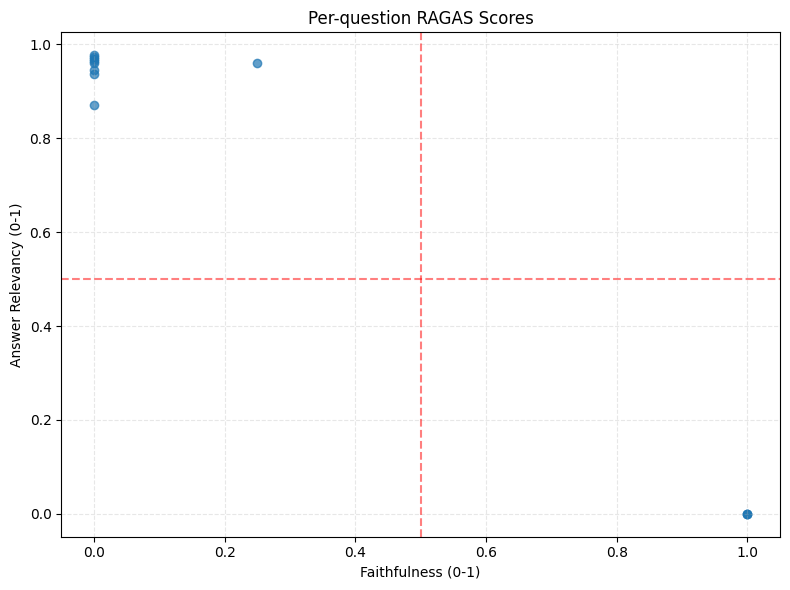

In [2]:
# Simple evaluation test
from src.rag import create_query_engine, run_full_evaluation
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

# Setup
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")
llm = OpenAI(model="gpt-4o-2024-11-20", temperature=0.1)
judge_llm = OpenAI(model="gpt-4o-2024-11-20", temperature=0.1)
Settings.embed_model = embed_model # We need to set up the embed_model globally.... gotta  think about it for the app

# Create query engine and evaluate
query_engine = create_query_engine("data/indices/medical_index", llm, embed_model)
results = run_full_evaluation(query_engine, judge_llm)

# Results include:
# - Faithfulness score (how well grounded in sources)
# - Answer relevancy score (how relevant to questions)  
# - Overall grade (A-F)
# - Scatter plot visualization

In [3]:
results

{'scores': {'faithfulness': 0.2708, 'answer_relevancy': 0.7131},
 'summary': {'num_questions': 12,
  'faithfulness_mean': np.float64(0.2708333333333333),
  'faithfulness_std': np.float64(0.44541009363860573),
  'answer_relevancy_mean': np.float64(0.7130575849133626),
  'answer_relevancy_std': np.float64(0.430874059949315),
  'detailed_scores': [{'user_input': 'What is the first-line antibiotic regimen for outpatient treatment of uncomplicated community-acquired bacterial pneumonia in an adult with no comorbidities?',
    'retrieved_contexts': ['Notably, for neurocritical care patients, strict glycemic control had no effect on patient mortality but increased the incidence of hypoglycemia (44). According to a systematic review and meta-analysis of optimal glycemic control in neurocritical care patients, a more conservative approach is the most appropriate (i.e., maintaining blood glucose levels of 110 mg/dL–180 mg/dL) (45). The variety of antibiotics used during the hospitalization of pa

In [ ]:
# Quick safety test
import sys
sys.path.append("../src")

from src.rag import create_query_engine
from src.safety import comprehensive_safety_check
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from sentence_transformers import SentenceTransformer

# Setup
#embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")
#llm = OpenAI(model="gpt-4o-mini", temperature=0.1)
#encoder = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
encoder = SentenceTransformer("all-MiniLM-L6-v2")

# Create query engine and test safety
query_engine = create_query_engine("data/indices/medical_index", llm, embed_model)
result = comprehensive_safety_check(
    "What antibiotics are safe with warfarin?", 
    query_engine, llm, encoder
)

print(f"Confidence: {result['confidence']}")
print(f"Safety Score: {result['safety_score']}/3")

=== COMPREHENSIVE MEDICAL RAG SAFETY CHECK ===
Using standard retrieval...

Question: What antibiotics are safe with warfarin?
Answer: The provided information does not specify which antibiotics are safe to use with warfarin. It is important to consult a healthcare professional or refer to clinical guidelines for advice on antibiotic...

=== ATTRIBUTION CHECK ===
Checking 2 sentences against 5 source chunks
Sentence 1: 'The provided information does not specify which an...' → Score: 0.424
Sentence 2: 'It is important to consult a healthcare profession...' → Score: 0.496

=== CONSISTENCY CHECK ===
Asking the same question 3 times...
Attempt 1...
Attempt 2...
Attempt 3...

=== ALL RESPONSES ===
Response 1: The provided information does not specify which antibiotics are safe to use with warfarin. It is imp...

Response 2: The provided information does not specify which antibiotics are safe to use with warfarin. It is imp...

Response 3: The provided information does not include details ab

In [3]:
# Test with external fact-checking
from src.rag import create_query_engine
from src.safety import comprehensive_safety_check
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from sentence_transformers import SentenceTransformer
from llama_index.core import Settings
#from src.safety import comprehensive_safety_check

# Setup
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")
llm = OpenAI(model="gpt-4o-2024-11-20", temperature=0.1)
encoder = SentenceTransformer("all-MiniLM-L6-v2")
Settings.embed_model = embed_model 
# Create query engine and test safety
query_engine = create_query_engine("data/indices/medical_index", llm, embed_model)

result = comprehensive_safety_check(
    "What antibiotics are safe with warfarin?",
    query_engine, llm, encoder,
    enable_fact_check=True  # NEW: Enable external validation
)

print(f"Internal Score: {result['attribution_score']:.3f}")
print(f"External Score: {result['fact_check_result']['combined_score']:.3f}")
print(f"Overall Confidence: {result['confidence']} ({result['safety_score']}/{result['max_safety_score']})")

=== COMPREHENSIVE MEDICAL RAG SAFETY CHECK ===
Using standard retrieval...

Question: What antibiotics are safe with warfarin?
Answer: The provided information does not specify which antibiotics are safe to use with warfarin. It is important to consult a healthcare professional or refer to clinical guidelines for advice on antibiotic...

=== ATTRIBUTION CHECK ===
Checking 2 sentences against 5 source chunks
Sentence 1: 'The provided information does not specify which an...' → Score: 0.424
Sentence 2: 'It is important to consult a healthcare profession...' → Score: 0.475

=== CONSISTENCY CHECK ===
Asking the same question 3 times...
Attempt 1...
Attempt 2...
Attempt 3...

=== ALL RESPONSES ===
Response 1: The provided information does not specify which antibiotics are safe to use with warfarin. It is imp...

Response 2: The provided information does not specify which antibiotics are safe to use with warfarin. It is imp...

Response 3: The provided information does not specify which anti

/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/ml_dev/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
